In [1]:
import numpy as np
import time
import math
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

## Load dataset

In [2]:
X_train, y_train = load_svmlight_file(f="a9a", n_features=123)
X_test, y_test = load_svmlight_file(f="a9a.t", n_features=123)

n_samples, n_features = X_train.shape

## Normalized y label

In [3]:
y_train = y_train.reshape((-1, 1))
y_train[y_train == -1] = 0 # restrict y to {0, 1}

y_test = y_test.reshape((-1, 1))
y_test[y_test == -1] = 0 # restrict y to {0, 1}

## Hyper-parameters

In [4]:
BATCH_SIZE = 64
LEARNING_RATE = 0.02
MAX_EPOCH = 2000
FUDGE_FACTOR = 1e-8  # parameter epsilon, guarantees nonzero denominator in Adagrad and Adam
FIRST_DECAY = 0.9  # param mu in Adam
SECOND_DECAY = 0.99  # param nu in Adam

## Sigmoid function

$$ g(z) = \frac{1}{1 + e^{-z}} $$

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Logistic loss function

$$ J(\theta) = -\frac{1}{n}\left[\sum_{i=1}^{n} y_i \log h_{\theta}(x_i) + (1-y_i)\log(1-h_{\theta}(x_i))\right] $$

### Vectorized loss function

$$ J(\theta) = -\frac{1}{n}\left((\log g(X\theta))^T y + (\log(1 - g(X\theta)))^T(1-y)\right) $$


In [6]:
def log_loss(wei, X, y):
    n = y.size
    h = sigmoid(X.dot(wei))
    J = -1/n * (np.log(h).T.dot(y) + np.log(1 - h).T.dot(1 - y)).sum()
    return J

## Gradient of loss function 

$$ \frac{\partial J(\theta)}{\partial\theta} = \frac{1}{n}\sum_{i=1}^{n}( h_{\theta}(x_i)-y_i)x_i $$ 

### Vectorized gradient

$$ \frac{\partial J(\theta)}{\partial\theta} = \frac{1}{m} X^T(g(X\theta)-y)$$

In [7]:
def grad(wei, X, y):
    m = y.size
    h = sigmoid(X.dot(wei))
    grad = (-1/m) * X.T.dot(h - y)
    return grad

## Predict function

In [8]:
def predict(w, X, thredshold=0.5):
    y_pred = sigmoid(X.dot(w))
    y_pred[y_pred >= thredshold] = 1
    y_pred[y_pred < thredshold] = 0
    return y_pred

## Initialize parameter $w$ with zeros

In [9]:
w = np.zeros((n_features, 1))

## Logistic regression with different methods
 
$$ g_t = \frac{1}{\left|S_k\right|}\sum_{i \in S_k}\nabla_{\theta}L_i(\theta) $$

### MSGD

$$ \Delta \theta_t = -\eta \cdot g_t $$

In [10]:
np.random.seed(int(time.time()))

msgd_losses_val = []
msgd_acc_val = []
for epoch in range(MAX_EPOCH):
    rand = np.random.randint(0, n_samples, size=BATCH_SIZE)
    X_batch = X_train[rand]
    y_batch = y_train[rand]
    G = grad(w, X_batch, y_batch)
    w = w + LEARNING_RATE * G

    loss_val = log_loss(w, X_test, y_test)
    msgd_losses_val.append(loss_val)
    
    y_pred = predict(w, X_test)
    acc = (y_pred == y_test).sum() / y_test.shape[0]
    msgd_acc_val.append(acc)

### Adagrad

$$ n_t = n_{t-1} + g_t^2 $$

$$ \Delta \theta_t = -\frac{\eta}{\sqrt{n_t} + \epsilon}g_t$$

In [11]:
adagrad_losses_val = []
adagrad_acc_val = []

w = np.zeros((n_features, 1))

grad_sqr_sum = 0
for epoch in range(MAX_EPOCH):
    rand = np.random.randint(0, n_samples, size=BATCH_SIZE)
    X_batch = X_train[rand]
    y_batch = y_train[rand]
    g = grad(w, X_batch, y_batch)
    grad_sqr_sum += g**2
    adgrad = g / (FUDGE_FACTOR + np.sqrt(grad_sqr_sum)) 
    w = w + LEARNING_RATE * adgrad
    
    loss_val = log_loss(w, X_test, y_test)
    adagrad_losses_val.append(loss_val)
    
    y_pred = predict(w, X_test)
    acc = (y_pred == y_test).sum() / y_test.shape[0]
    adagrad_acc_val.append(acc)

### Adam

$$ m_t = \mu \cdot m_{t-1} + (1-\mu)\cdot g_t $$

$$ n_t = \nu \cdot n_{t-1} + (1-\nu)\cdot g_t^2 $$

$$ \hat m_t = \frac{m_t}{1-\mu^t} $$

$$ \hat n_t = \frac{n_t}{1-\nu^t} $$

$$ \Delta\theta_t = -\frac{\hat m_t}{\sqrt{\hat n_t} + \epsilon} \cdot \eta $$

In [12]:
adam_losses_val = []
adam_acc_val = []

w = np.zeros((n_features, 1))

bias_first_est, bias_second_est = 0, 0
for epoch in range(MAX_EPOCH):
    rand = np.random.randint(0, n_samples, size=BATCH_SIZE)
    X_batch = X_train[rand]
    y_batch = y_train[rand]
    g = grad(w, X_batch, y_batch)
    
    bias_first_est = FIRST_DECAY * bias_first_est + (1-FIRST_DECAY) * g
    bias_second_est = SECOND_DECAY * bias_second_est + (1-SECOND_DECAY) * g**2
    bia_corr_first_est = bias_first_est / (1 - math.pow(FIRST_DECAY, epoch + 1))
    bia_corr_second_est = bias_second_est / (1 - math.pow(SECOND_DECAY, epoch + 1))
    adamgrad = bia_corr_first_est / (np.sqrt(bia_corr_second_est) + FUDGE_FACTOR)
    
    w = w + LEARNING_RATE * adamgrad
    
    loss_val = log_loss(w, X_test, y_test)
    adam_losses_val.append(loss_val)
    
    y_pred = predict(w, X_test)
    acc = (y_pred == y_test).sum() / y_test.shape[0]
    adam_acc_val.append(acc)

## Plot

### Loss

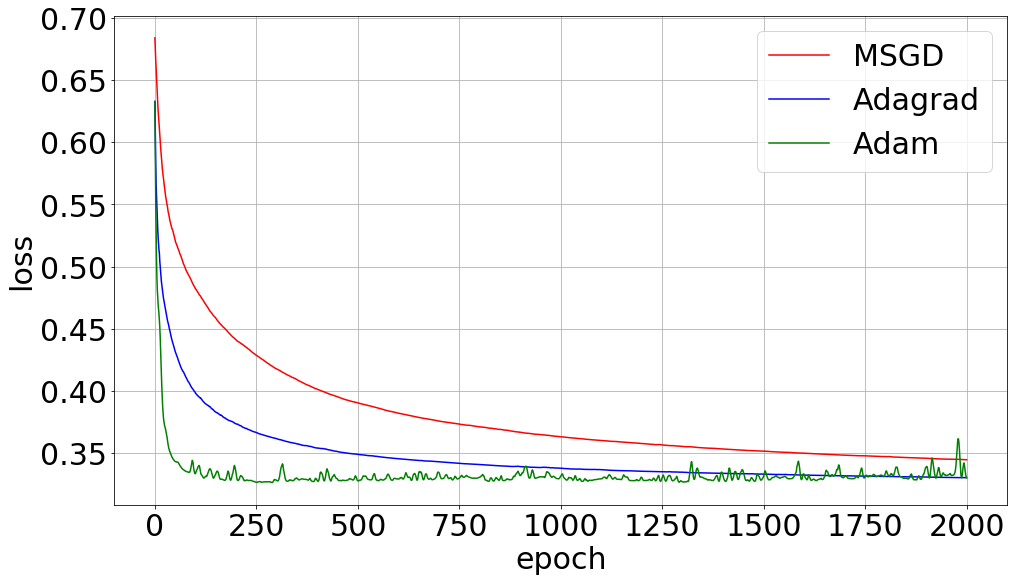

In [13]:
ftsize=30
plt.figure(figsize=(16, 9))
plt.xticks(fontsize=ftsize)
plt.yticks(fontsize=ftsize)
plt.plot(msgd_losses_val, "-", color="r", label="MSGD")
plt.plot(adagrad_losses_val, "-", color="b", label="Adagrad")
plt.plot(adam_losses_val, "-", color="g", label="Adam")
plt.xlabel("epoch", fontsize=ftsize)
plt.ylabel("loss", fontsize=ftsize)
plt.legend(fontsize=ftsize)
plt.grid()
plt.savefig('log_loss.png')
# plt.title("The graph of logistic loss with different GD algorithms")
plt.show()

### Accuracy

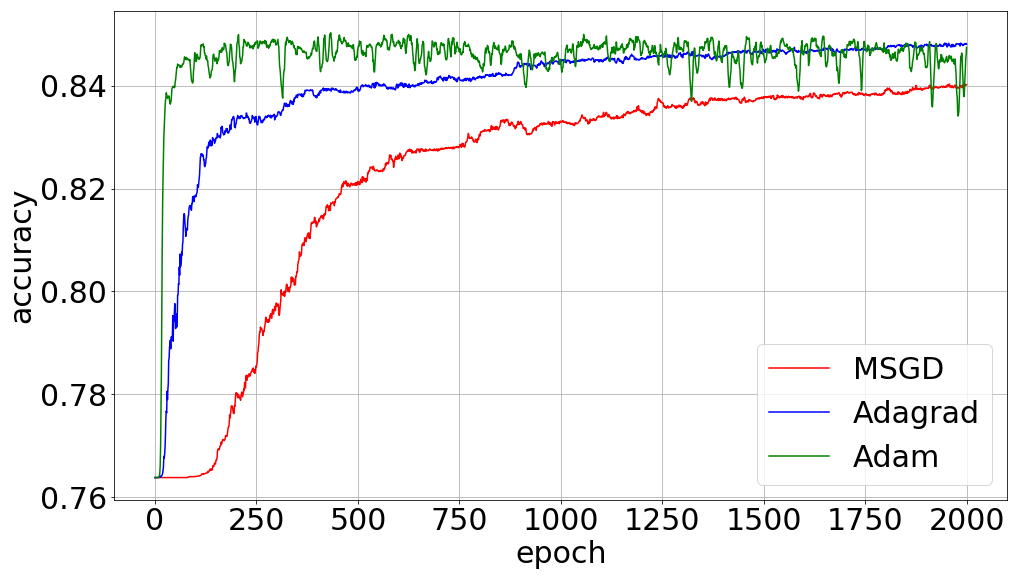

In [14]:
plt.figure(figsize=(16, 9))
plt.xticks(fontsize=ftsize)
plt.yticks(fontsize=ftsize)
plt.plot(msgd_acc_val, "-", color="r", label="MSGD")
plt.plot(adagrad_acc_val, "-", color="b", label="Adagrad")
plt.plot(adam_acc_val, "-", color="g", label="Adam")
plt.xlabel("epoch", fontsize=ftsize)
plt.ylabel("accuracy", fontsize=ftsize)
plt.legend(fontsize=ftsize)
plt.grid()
plt.savefig('log_accuracy.png')
#plt.title("The graph of prediction accuracy with different algorithms")
plt.show()